In [12]:
import numpy as np

from scipy.stats import binom
from scipy.stats.contingency import expected_freq
from scipy.stats import chi2_contingency
from scipy.stats import chisquare, chi2

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
FIG_SIZE = (15,5)

In [7]:
def sample_and_calc_chisq(n1, n2, p1, p2):

    # setup 2 binomial random variables (rv1, rv2) that represent the true population proportions
    rv1 = binom(n=n1, p=p1)
    rv2 = binom(n=n2, p=p2) 

    # take a sample from each rv
    x1 = rv1.rvs()
    x2 = rv2.rvs()

    # calculate observed values using margin totals and sampled values x1 and x2
    obs = np.array([[x1, n1 - x1], [x2, n2 - x2]])
    
    # calculate expected values
    exp = expected_freq(observed=obs)

    # calculate degrees of freedom
    ddof = (np.shape(obs)[0]-1) * (np.shape(obs)[1]-1)

    # compute chi-squared test statistic 
    terms = (obs.astype(np.float64) - exp)**2 / exp # don't apply continuity correction
    chisq = terms.flatten().sum()
    
    return chisq

In [40]:
# set up arguments 
n1 = 100 # group 1 total
n2 = 100 # group 2 total
p1 = 0.5 # group 1 incident rate
p2 = 0.5 # group 2 incident rate

# setup number of samples we'll be taking
n_samples = 2000

# setup array to store sampled chi-square test statistics
_chisq = []

# take repeated samples and calculate the chi-square test statistic for each one, then add to list 
for _ in range(n_samples):
    chisq = sample_and_calc_chisq(n1, n2, p1, p2)
    _chisq.append(chisq)     # save in array 

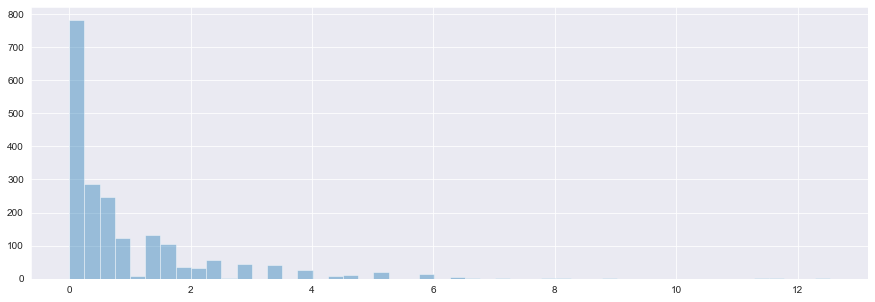

In [41]:
plt.figure(figsize=FIG_SIZE)
# stat{“count”, “frequency”, “density”, “probability”}
sns.distplot(_chisq, kde=False, kde_kws={'shade':True});

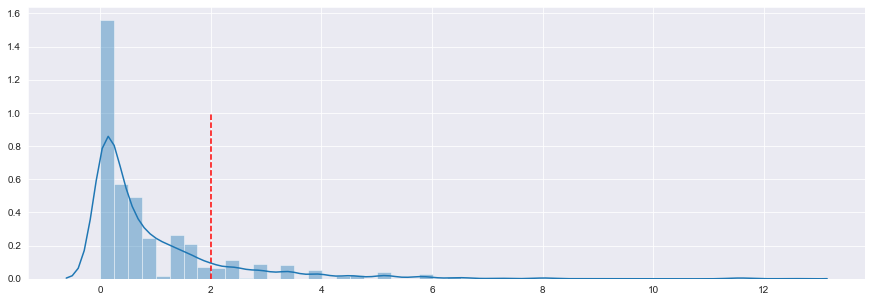

In [47]:
p1 = 0.50
p2 = 0.50
chisq = sample_and_calc_chisq(n1, n2, p1=p1, p2=p2)

# plot
plt.figure(figsize=FIG_SIZE)
sns.distplot(_chisq);
plt.vlines(x=chisq, ymin=0, ymax=1.0, color='r', ls='--')

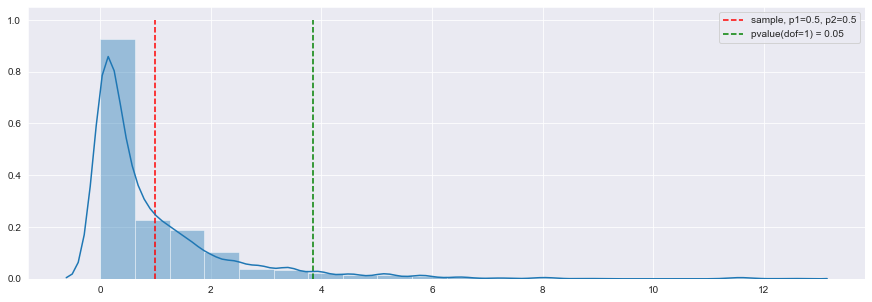

In [43]:
# plot distribution, sample chisq, and sample chisq that represents a p-value of 0.05 
df = 1
pvalue = 0.05
threshold = chi2.ppf(1-pvalue, df)

p1 = 0.50
p2 = 0.50
chisq = sample_and_calc_chisq(n1, n2, p1=p1, p2=p2)

# plot
plt.figure(figsize=FIG_SIZE)
sns.distplot(_chisq, bins=20);
plt.vlines(x=chisq, ymin=0, ymax=1.0, color='r', ls='--', label=f'sample, p1={p1}, p2={p2}')
plt.vlines(x=threshold, ymin=0, ymax=1.0, color='g', ls='--', label=f'pvalue(dof={df}) = 0.05')
plt.legend()

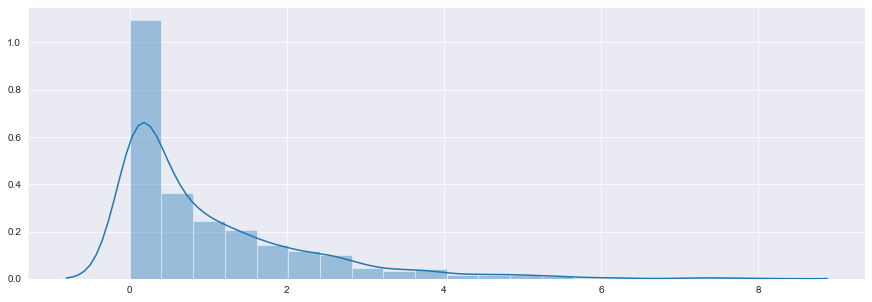

In [44]:
# sample
r = chi2.rvs(df=1, size=1000)

# plot
plt.figure(figsize=FIG_SIZE)
sns.distplot(r, bins=20);